## Question 4

Assume have the following portfolio as of 2016/01/01:

AAPL.O 15%

IBM.N 20%

GOOG.O 20%

BP.N 15%

XOM.N 10%

COST.O 15%

GS.N 5%

a. Using historical daily returns (Yahoo/Google Finance or any other market data source), calculate VaR95% and CVaR95% of the portfolio as of 2016/12/31

b. Using expected mean, covariance matrix and parametric method, calculate VaR95% and CVaR95%

c. Assume you can change weights, allow shorting but no leverage (i.e. sum of weights equal 100%), and rebalance monthly. What is the optimal portfolio holding by end of each month till end of 2016

Notes: If you have other assumption(s) please state clearly

## Historical Method

In [4]:
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm,t
import matplotlib.pyplot as plt

In [5]:
def getData(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

In [6]:
# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

In [7]:
portfolio_list = ["AAPL","IBM","GOOG","BP","XOM","COST","GS"]
end_date = dt.datetime.now()
start_date = '2016-01-01'

In [8]:
returns,meanReturns, covMatrix = getData(portfolio_list,start = start_date , end = end_date )
#drop the missing values of the dataset
returns  = returns.dropna()
#set weights
weights = np.array([0.15,0.2,0.2,0.15,0.1,0.15,0.05])
# factoring weights into returns to get portfolio returns
returns['portfolio'] = returns.dot(weights)
returns

Symbols,AAPL,IBM,GOOG,BP,XOM,COST,GS,portfolio
Date,,,,,,,,
2016-01-04,0.000855,-0.012135,-0.022454,-0.006398,-0.006286,-0.012136,-0.017145,-0.011056
2016-01-05,-0.025059,-0.000735,0.000998,-0.004185,0.008521,0.002445,-0.017218,-0.003976
2016-01-06,-0.019570,-0.005006,0.001400,-0.020369,-0.008321,-0.009254,-0.024413,-0.010153
2016-01-07,-0.042205,-0.017090,-0.023170,-0.028713,-0.016006,-0.022909,-0.030735,-0.025263
2016-01-08,0.005288,-0.009258,-0.016410,-0.017669,-0.020202,-0.017504,-0.004131,-0.011843
...,...,...,...,...,...,...,...,...
2021-08-16,0.013548,0.002864,0.003685,-0.019429,-0.014620,0.011254,-0.005916,0.000358
2021-08-17,-0.006154,-0.008148,-0.011629,0.001618,-0.006793,-0.001148,-0.008277,-0.005901
2021-08-18,-0.025501,-0.020713,-0.005320,-0.016956,-0.021058,-0.013552,-0.015236,-0.016476


In [19]:
def historicalVar(returns, conf_level = 5):
    """ Read in pd df/series of returns
        Output percentile of distribution at the conf_level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, conf_level)
    
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVar, conf_level = 5) #Passed as Series recursion function
    
    else:
        raise TypeError("expected returns to be df or series")
        

In [20]:
historicalVar(returns['portfolio'])

-0.01808003516494755

In [21]:
def historicalCVar(returns,conf_level_cvar = 5):
    
    if isinstance(returns, pd.Series):
        belowVar = returns <= historicalVar(returns, conf_level = conf_level_cvar)
        return returns[belowVar].mean()
    
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVar, conf_level_cvar = 5)
    
    else:
        raise TypeError("expected returns to be df or series")
    

In [22]:
historicalCVar(returns)

Symbols
AAPL        -0.043644
IBM         -0.040580
GOOG        -0.040003
BP          -0.048715
XOM         -0.042442
COST        -0.030665
GS          -0.044919
portfolio   -0.031073
dtype: float64

In [24]:
CVar = historicalCVar(returns['portfolio'],conf_level_cvar = 5)*np.sqrt(1)
Var = historicalVar(returns['portfolio'],conf_level =5)*np.sqrt(1)

print("Var = ", Var)
print("CVaR = ", CVar)

Var =  -0.01808003516494755
CVaR =  -0.031072912755324405


In [25]:
Time = 1 # 1 day
initial_investment = 100000


CVar = -1* historicalCVar(returns['portfolio'])*np.sqrt(Time)
Var = -1* historicalVar(returns['portfolio'])*np.sqrt(Time)
portfolio_return, portfolio_std = portfolioPerformance(weights, meanReturns, covMatrix, Time)

print("Var = ", Var)
print("CVaR = ", CVar)
print("expected portfolio return,  ", round(initial_investment * portfolio_return,2))
print("value at risk 95% CI", round(initial_investment * Var,2))
print("conditional value at risk 95% CI", round(initial_investment * CVar,2))

Var =  0.01808003516494755
CVaR =  0.031072912755324405
expected portfolio return,   60.19
value at risk 95% CI 1808.0
conditional value at risk 95% CI 3107.29


## Parametric Var & CVar

In [26]:
def var_parametric(portfolioReturn, portfolioStd, distribution = 'normal', conf_level = 5, dof = 6):
    """Calculate the portfolio VaR given a distribution, with known params"""
    
    if distribution == 'normal':
        Var = norm.ppf(1-conf_level/100)*portfolioStd - portfolioReturn #Take RHS as it is the profit
        
    elif distribution == 't-distribution':
        v = dof
        Var = np.sqrt((v-2)/v*t.ppf(1-conf_level/100, v))*portfolioStd - portfolioReturn
        
    else:
        raise TypeError("Expected distribution to be normal or t distribution")
        
    return Var
        
    

In [27]:
def Cvar_parametric(portfolioReturn, portfolioStd, distribution = 'normal', conf_level = 5, dof = 6):
    """Calculate the portfolio VaR given a distribution, with known params"""
    
    if distribution == 'normal':
        CVar = (conf_level/100)**-1*norm.pdf(norm.ppf(conf_level/100))*portfolioStd - portfolioReturn #Take RHS as it is the profit
        
    elif distribution == 't-distribution':
        v = dof
        x_v = t.ppf(conf_level/100,v)
        CVar = -1/(conf_level/100)*(1-v)**-1 * (v-2+x_v**2)*t.pdf(x_v,v)*portfolioStd - portfolioReturn
        
    else:
        raise TypeError("Expected distribution to be normal or t distribution")
        
    return CVar

In [28]:
normVar = var_parametric(portfolio_return, portfolio_std)
normCVar = Cvar_parametric(portfolio_return, portfolio_std)
tVar = var_parametric(portfolio_return, portfolio_std, distribution = 't-distribution')
tCVar = Cvar_parametric(portfolio_return, portfolio_std,distribution = 't-distribution')

print("normal value at risk 95% CI: ", round(initial_investment * normVar,2))
print("normal conditional value at risk 95% CI: ", round(initial_investment * normCVar,2))
print("T value at risk 95% CI: ", round(initial_investment * tVar,2))
print("T conditional value at risk 95% CI: ", round(initial_investment * tCVar,2))

normal value at risk 95% CI:  2029.02
normal conditional value at risk 95% CI:  2559.77
T value at risk 95% CI:  1385.47
T conditional value at risk 95% CI:  2678.47


## Using MonteCarlo

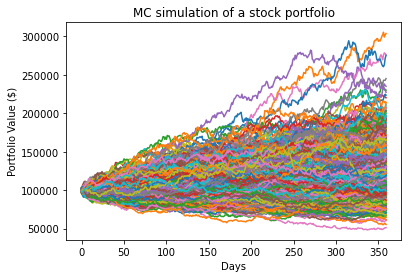

In [29]:
returns,meanReturns, covMatrix = getData(portfolio_list,start = start_date , end = end_date )
#montecarlo method
# number of simulation

mc_sims = 1000
initial_investment = 100000
T = 360 # time frame in days
meanM  = np.full(shape = (T,len(weights)), fill_value = meanReturns)
meanM_trans = meanM.T

portfolio_sims = np.full(shape = (T,mc_sims), fill_value = 0.0)

for m in range(0, mc_sims):
    #MC Loops
    Z = np.random.normal(size =(T,len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM_trans + np.inner(L,Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)* initial_investment
    
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

6. In a text file, give me total number of appearance of “date” within the text file The date format can appears in either one (or multiple) formats shown below: 

a. YYYY/MM/DD 

b. MM/DD/YYYY 

c. DD/MM/YYYY 

d. DD (Jan/Feb/Mar/Apr/May/Jun/Jul/Aug/Sept/Oct/Nov/Dec) YYYY


In [33]:
import re
from datetime import datetime

In [34]:
with open('date.txt') as file:
    lines = file.readlines()
    string_line = ""
    for i in lines:
        string_line = string_line + i.split('\n')[0]
        
print(string_line)

Today the date is 1998/12/31 or it can be 01/12/2018 or another order 31/12/2019 the last variation is 12 Jan 2020.Tomorrow date is 1998/01/31 or it can be 12/02/2015 or another order 21/12/2014 the last variation is 12 Jan 2020.


In [35]:
a = re.findall("[0-9][0-9][0-9][0-9]/[0-9][0-9]/[0-9][0-9]",lines[0])
b = re.findall("[0-9][0-9]/[0-9][0-9]/[0-9][0-9][0-9][0-9]",lines[0])
c = re.findall("[0-9][0-9] [A-Z][a-z][a-z] [0-9][0-9][0-9][0-9]",lines[0])

In [36]:
def find_dates(sentence_input):
    case = []
    catch_a = re.findall("[0-9][0-9][0-9][0-9]/[0-9][0-9]/[0-9][0-9]",sentence_input)
    catch_b = re.findall("[0-9][0-9]/[0-9][0-9]/[0-9][0-9][0-9][0-9]",sentence_input) 
    catch_c = re.findall("[0-9][0-9] [A-Z][a-z][a-z] [0-9][0-9][0-9][0-9]",sentence_input)
    case = catch_a + catch_b + catch_c
    
    return count_freq(case)
        
        
       

In [37]:
def catch_date(date_input):
    a = False 
    try:
        datetime_object = datetime.strptime(date_input, '%Y/%m/%d')
        a = True
    except:
        next 
    try:
        datetime_object = datetime.strptime(date_input, '%m/%d/%Y')
        a = True
        
    except:
        next
        
    try:
        datetime_object = datetime.strptime(date_input, '%d %b %Y')
        a = True
    except:
        next
        
    try:
        datetime_object = datetime.strptime(date_input, '%d/%m/%Y')
        a = True
    except:
        next
        
    return a        
    
    
        
    

In [40]:
def count_freq(cases):
    count = 0
    for  i in cases:
        count += catch_date(i)
    return count

In [41]:
find_dates(string_line)

8